
1/1 [==============================] - 1s 957ms/step


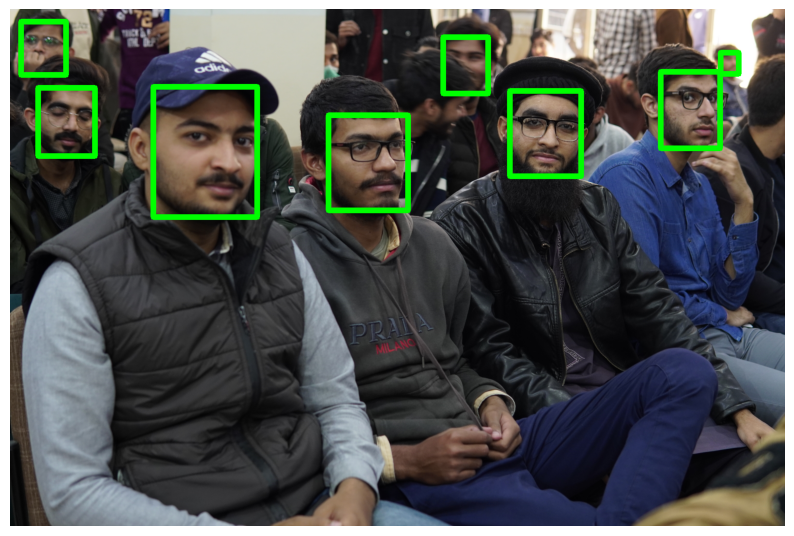

1/1 [==============================] - 1s 965ms/step


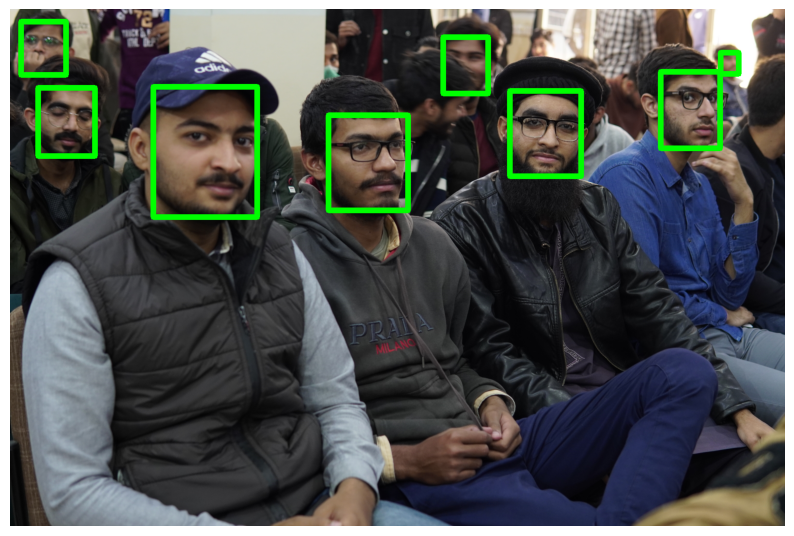

1/1 [==============================] - 1s 967ms/step


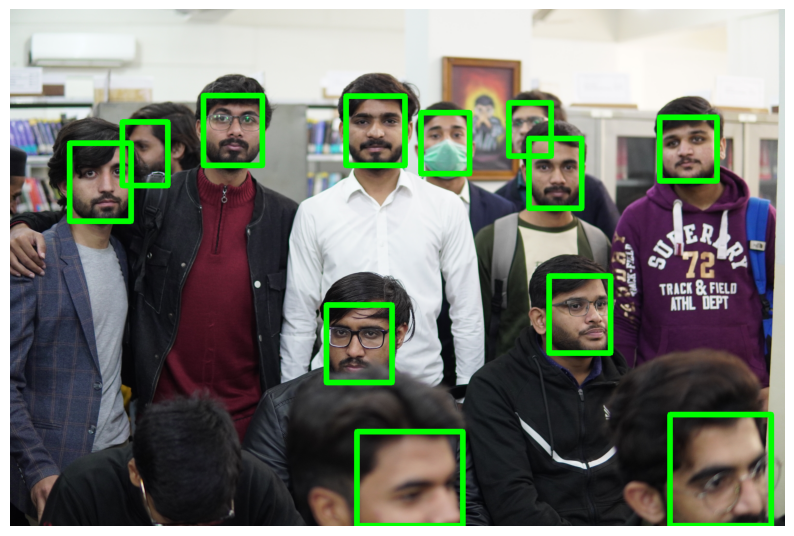

1/1 [==============================] - 1s 964ms/step


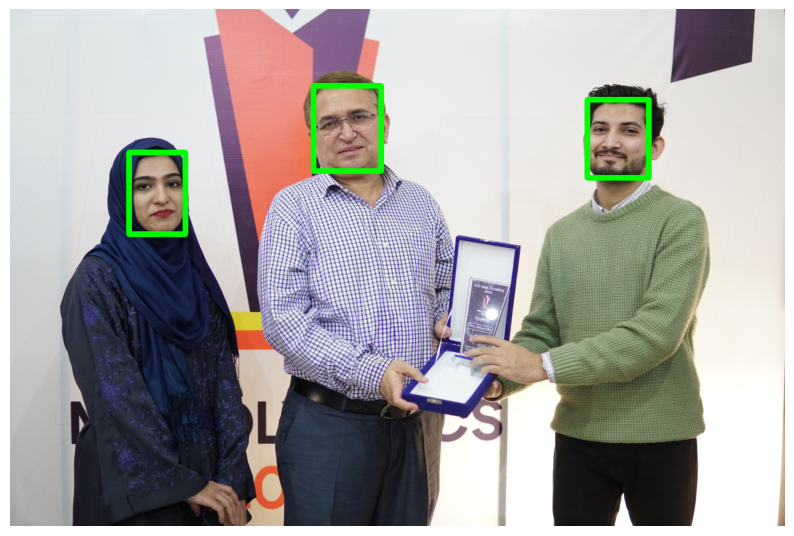

In [1]:
import os
import cv2
import pickle
import numpy as np
from matplotlib import pyplot as plt
from retinaface import RetinaFace
from keras_facenet import FaceNet
from scipy.spatial.distance import cosine

class FaceRecognition:
    def __init__(self, scale_factor=0.25, threshold=0.6):
        self.scale_factor = scale_factor
        self.threshold = threshold
        self.facenet = FaceNet()
        self.event_dict = self.load_event_data()

    def load_event_data(self):
        try:
            with open('face_embeddings.pkl', 'rb') as f:
                return pickle.load(f)
        except (FileNotFoundError, EOFError):
            return {}

    def save_event_data(self):
        with open('face_embeddings.pkl', 'wb') as f:
            pickle.dump(self.event_dict, f)

    def resize_image(self, img):
        width = int(img.shape[1] * self.scale_factor)
        height = int(img.shape[0] * self.scale_factor)
        return cv2.resize(img, (width, height), interpolation=cv2.INTER_AREA)

    def detect_faces(self, img_rgb):
        return RetinaFace.detect_faces(img_rgb)

    def process_faces(self, faces, img_rgb, image_path, face_dict):
        for key, face in faces.items():
            facial_area = face["facial_area"]
            face_img = img_rgb[facial_area[1]:facial_area[3], facial_area[0]:facial_area[2]]
            face_img = cv2.resize(face_img, (160, 160))
            embedding = self.facenet.embeddings([face_img])[0]

            found = False
            for key_existing in face_dict:
                similarity = 1 - cosine(key_existing, embedding)
                if similarity > self.threshold:
                    face_dict[key_existing].append(image_path)
                    found = True
                    break

            if not found:
                face_dict[tuple(embedding)] = [image_path]

            cv2.rectangle(img_rgb, 
                          (facial_area[0], facial_area[1]), 
                          (facial_area[2], facial_area[3]), 
                          (0, 255, 0), 10)
    
    def show_image(self, img_rgb):
        plt.figure(figsize=(10, 10))
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.show()

    def process_event_images(self, event_name, image_dir):
        if event_name not in self.event_dict:
            self.event_dict[event_name] = {}

        face_dict = self.event_dict[event_name]

        if not os.path.exists(image_dir):
            raise FileNotFoundError(f"Error: The directory {image_dir} does not exist.")
        image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

        for image_path in image_paths:
            img = cv2.imread(image_path)
            img_resized = self.resize_image(img)
            img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
            faces = self.detect_faces(img_rgb)
            self.process_faces(faces, img_rgb, image_path, face_dict)
            self.show_image(img_rgb)

        self.save_event_data()

    def find_similar_faces(self, event_name, input_image_path):
        if event_name not in self.event_dict:
            print(f"No data found for event: {event_name}")
            return []

        face_dict = self.event_dict[event_name]

        img = cv2.imread(input_image_path)
        img_resized = self.resize_image(img)
        img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
        faces = self.detect_faces(img_rgb)
        matching_directories = []

        for key, face in faces.items():
            facial_area = face["facial_area"]
            face_img = img_rgb[facial_area[1]:facial_area[3], facial_area[0]:facial_area[2]]
            face_img = cv2.resize(face_img, (160, 160))
            input_embedding = self.facenet.embeddings([face_img])[0]

            for key_existing, image_paths in face_dict.items():
                similarity = 1 - cosine(key_existing, input_embedding)
                if similarity > self.threshold:
                    matching_directories.extend(image_paths)

        matching_directories = list(set(matching_directories))  # Remove duplicates
        return matching_directories

if __name__ == "__main__":
    face_recognition = FaceRecognition()

    # Example for processing event images
    event_name = "Event1"
    image_dir = r'C:\Users\dell\Machine Learning\Project\Event3_images'
    face_recognition.process_event_images(event_name, image_dir)


In [6]:

# Example for finding similar faces in an event
input_image_path = r'C:\Users\dell\Machine Learning\Project\Event1_images\DSC00602.JPG'
matching_directories = face_recognition.find_similar_faces(event_name, input_image_path)
print("Matching directories:", matching_directories)


1/1 [==============================] - 1s 1s/step
Matching directories: ['C:\\Users\\dell\\Machine Learning\\Project\\Event3_images\\DSC00333.JPG']
